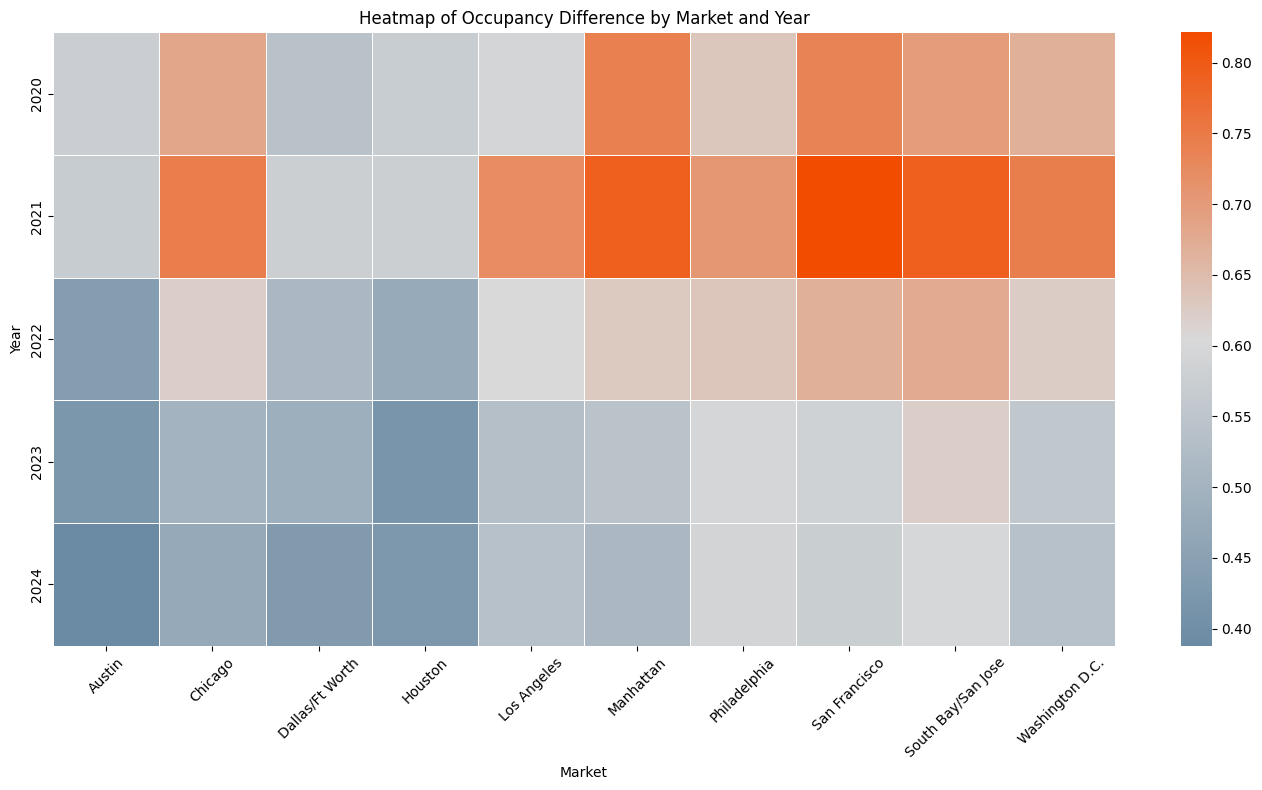

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


df = pd.read_csv("/Major Market Occupancy Data-revised.csv")


df['Difference'] = 1 - df['avg_occupancy_proportion']


heatmap_data = df.pivot_table(index='year', columns='market', values='Difference', aggfunc='mean')

custom_cmap = LinearSegmentedColormap.from_list(
    "bluegray_lightgray_red",
    ["#6b8ba4", "#d9d9d9", "#F24C00"],  # custom gradient colors
    N=256
)


plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap= custom_cmap, annot=False, linewidths=0.5)

plt.title("Heatmap of Occupancy Difference by Market and Year")
plt.xlabel("Market")
plt.ylabel("Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interpretation
We see the difference from March 1, 2020 to March 1, 2024. This graph tells about the increase/decrease of the lease holders based off the baseline. During 2020, disregarding the baseline, there is a increase

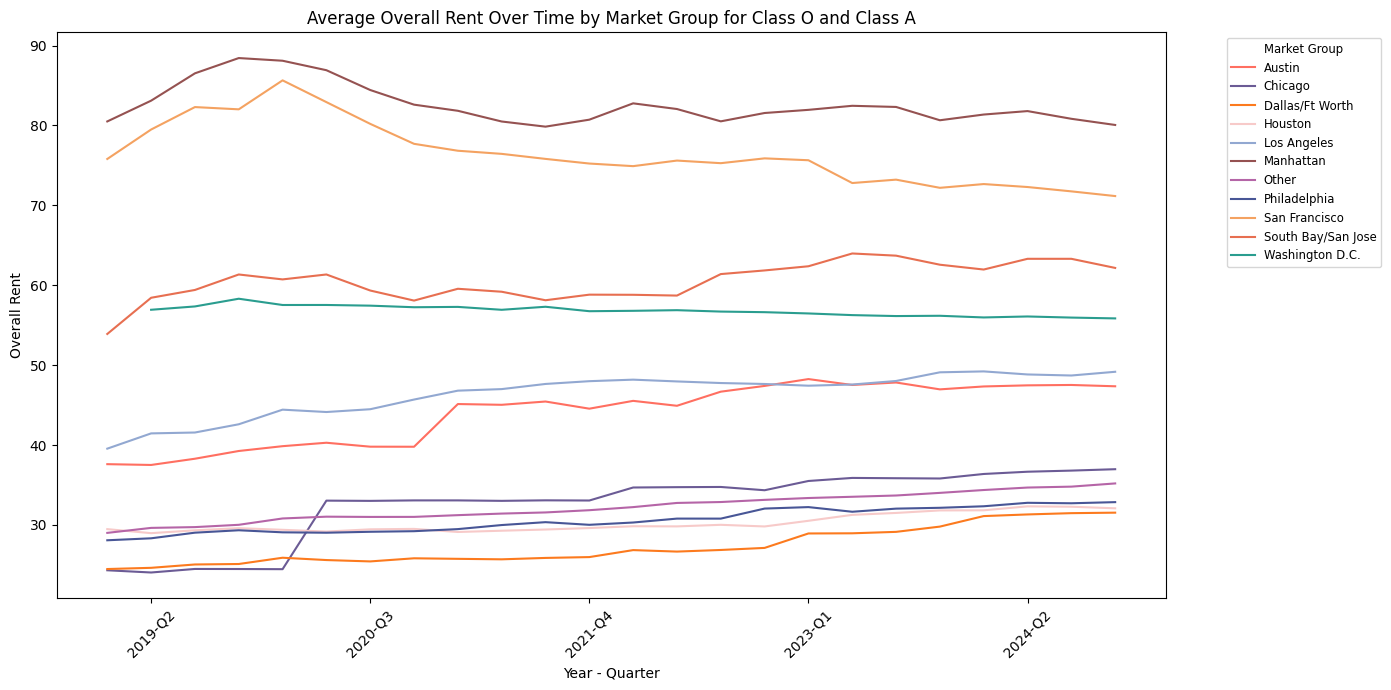

In [23]:
priceav = pd.read_csv("/Price and Availability Data.csv")

priceavO = priceav[priceav['internal_class']=='A'].copy()

target_markets = [
    "Austin", "Downtown Chicago", "Chicago Suburbs", "Dallas-Ft. Worth", "Houston",
    "Los Angeles", "Manhattan", "Philadelphia", "San Francisco", "South Bay",
    "Washington DC"
]

def categorize_market(market):
    if market in ["Downtown Chicago", "Chicago Suburbs"]:
        return "Chicago"
    elif market == "Dallas-Ft. Worth":
        return "Dallas/Ft Worth"
    elif market == "South Bay":
        return "South Bay/San Jose"
    elif market == "Washington DC":
        return "Washington D.C."
    elif market in target_markets:
        return market
    else:
        return "Other"


priceavO["market-group"] = priceavO["market"].apply(categorize_market)


priceavO["year-quarter"] = priceavO["year"].astype(str) + "-" + priceavO["quarter"]

groupedO = priceavO.groupby(["year-quarter", "market-group"])["direct_overall_rent"].mean().unstack()

colors = [
    "#ff6f61",  # coral
    "#6b5b95",  # indigo
    "#FC7A1E",  # orange
    "#f7cac9",  # pink blush
    "#92a8d1",  # light blue
    "#955251",  # mauve
    "#b565a7",  # lavender purple
    "#485696",  # blue
    "#f4a261",  # sandy orange
    "#e76f51",  # tomato red
    "#2a9d8f"   # turquoise
]

ax = groupedO.plot(figsize=(14, 7), color=colors)

plt.title("Average Overall Rent Over Time by Market Group for Class O and Class A")
plt.xlabel("Year - Quarter")
plt.ylabel("Overall Rent")
plt.xticks(rotation=45)




plt.legend(title="Market Group", fontsize="small", title_fontsize="small",
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




The cities which showed the most red in the heatmap also had a higher rent during COVID pandemic.

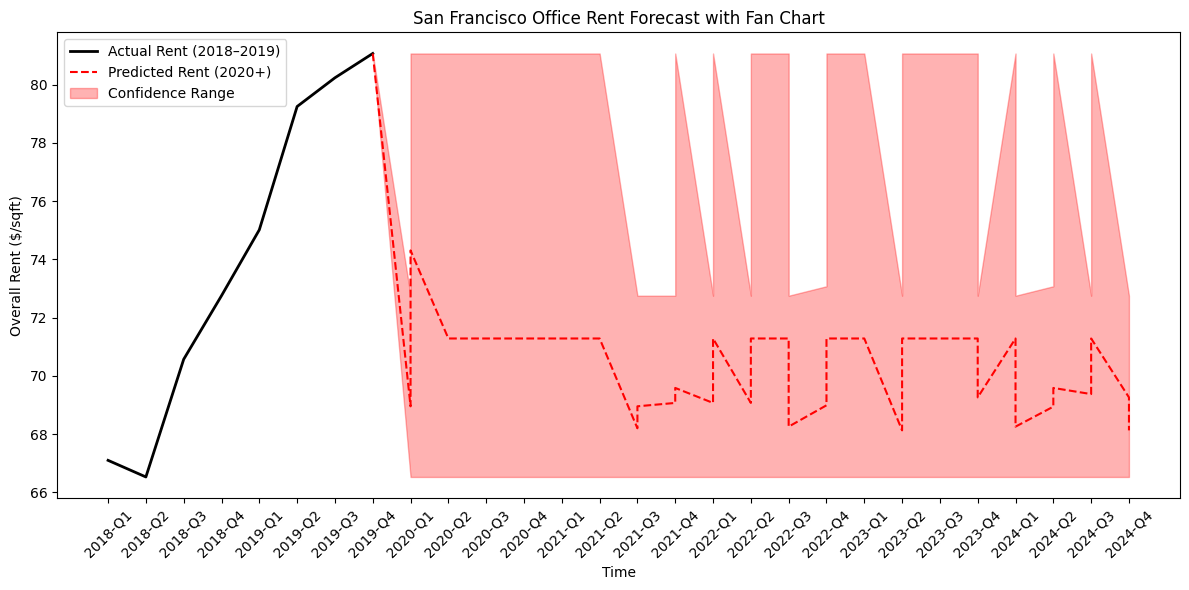

In [24]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

columns_to_fill = ["availability_proportion", "RBA", "leasing", "overall_rent"]

for col in columns_to_fill:
    priceav[col] = priceav.groupby("year")[col].transform(lambda x: x.fillna(x.mean()))

sf_train = priceav[priceav["year"] < 2020]
sf_train = sf_train[sf_train["market"] == "San Francisco"]
sf_train["available_space_est"] = sf_train["availability_proportion"] * sf_train["RBA"]
X_train = sf_train[["available_space_est", "leasing"]]
y_train = sf_train["overall_rent"]

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

sf_test = priceav[priceav["year"] >= 2020]
sf_test = sf_test[sf_test["market"] == "San Francisco"]
sf_test["available_space_est"] = sf_test["availability_proportion"] * sf_test["RBA"]
X_test = sf_test[["available_space_est", "leasing"]]
X_test_array = X_test.values

all_preds = np.stack([tree.predict(X_test_array) for tree in model.estimators_])
sf_test["mean_pred"] = np.mean(all_preds, axis=0)
sf_test["lower"] = np.percentile(all_preds, 5, axis=0)
sf_test["upper"] = np.percentile(all_preds, 95, axis=0)
sf_test["year_quarter"] = sf_test["year"].astype(str) + "-" + sf_test["quarter"]

sf_test = sf_test.sort_values(by=["year", "quarter"]).reset_index(drop=True)
sf_train = sf_train.sort_values(by=["year", "quarter"]).reset_index(drop=True)

last_actual = sf_train.iloc[-1]
transition_row = {
    "year_quarter": last_actual["year"].astype(str) + "-" + last_actual["quarter"],
    "mean_pred": last_actual["overall_rent"],
    "lower": last_actual["overall_rent"],
    "upper": last_actual["overall_rent"]
}
sf_test = sf_test.copy()
sf_test.loc[-1] = transition_row
sf_test = sf_test.sort_values(by="year_quarter").reset_index(drop=True)

x_pre = sf_train["year"].astype(str) + "-" + sf_train["quarter"]
y_pre = sf_train["overall_rent"]

x_post = sf_test["year_quarter"]
mean_pred = sf_test["mean_pred"]
lower_bound = sf_test["lower"]
upper_bound = sf_test["upper"]

plt.figure(figsize=(12, 6))
plt.plot(x_pre, y_pre, label="Actual Rent (2018–2019)", color="black", linewidth=2)
plt.plot(x_post, mean_pred, label="Predicted Rent (2020+)", color="red", linestyle="--")
plt.fill_between(x_post, lower_bound, upper_bound, color="red", alpha=0.3, label="Confidence Range")
plt.title("San Francisco Office Rent Forecast with Fan Chart")
plt.xlabel("Time")
plt.ylabel("Overall Rent ($/sqft)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<Axes: xlabel='year', ylabel='overall_rent'>

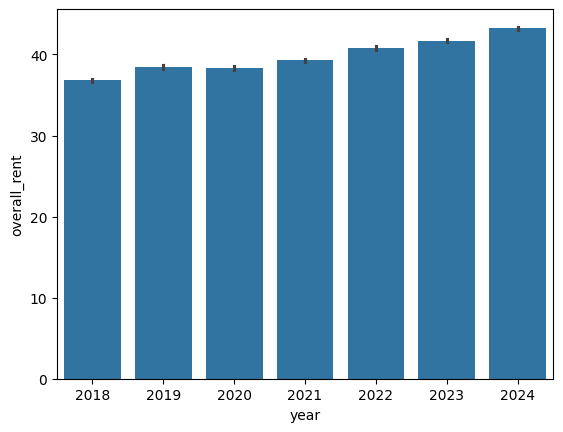

In [25]:
from google.colab import files
#uploaded = files.upload()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



df = pd.read_csv("/Leases.csv")
df1 = pd.read_csv("/Unemployment.csv")
#df.describe()
import seaborn as sns
#sns.pairplot(df[['quiz_score', 'time_spent', 'videos_watched']])

df.head()
#df.columns
#df.isnull().sum()
df1_small = df[['year']]
df2_small = df1[['year']]

#merged = pd.merge(df1_small, df2_small, on='year')

sns.barplot(x='year', y='overall_rent', data=df)

In [26]:
df['year-quarter'] = df['year'].astype(str) + " - " + df['quarter'].astype(str)

<Axes: xlabel='year-quarter'>

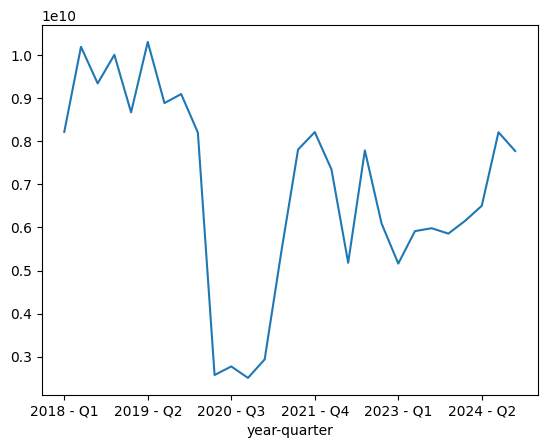

In [27]:
df.groupby('year-quarter')['leasing'].sum().plot()

In [28]:
df4 = pd.read_csv("/Price and Availability Data.csv")
df4


,year,quarter,market,internal_class,RBA,available_space,availability_proportion,internal_class_rent,overall_rent,direct_available_space,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing
0,2018,Q1,Atlanta,A,101140416,20239067,0.200109,27.655891,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1205126
1,2018,Q1,Atlanta,O,65810449,12728989,0.193419,18.560886,24.345689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715742
2,2018,Q1,Austin,A,36815073,4281986,0.116311,40.384706,36.596618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1738905
3,2018,Q1,Austin,O,27947525,3360936,0.121082,30.118658,36.596618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185674
4,2018,Q1,Baltimore,A,41033288,6813380,0.166045,27.104835,22.954034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,2024,Q4,Tampa,O,29139850,4891754,0.168000,25.600000,29.460000,3967413.0,0.0731,25.777557,29.801662,924341.0,0.0170,22.768426,24.797899,328947
1676,2024,Q4,US National,A,2169354031,586068996,0.270158,46.334337,42.613280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39807227
1677,2024,Q4,US National,O,1523470578,330685103,0.217060,36.044612,42.613280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16908043
1678,2024,Q4,Washington DC,A,80230758,18391159,0.229000,58.210000,54.610000,16054053.0,0.1308,59.964180,55.853040,2337106.0,0.0190,45.257017,43.481009,1557329


In [29]:
#all empty office spaces
df4_vacancy = df4['market'].value_counts()
df4_vacancy

,count
market,
Atlanta,56
Austin,56
Baltimore,56
Boston,56
Charlotte,56
Chicago Suburbs,56
Dallas-Ft. Worth,56
Denver-Boulder,56
Detroit,56


/tmp/ipython-input-30-3365656957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_SF['year-quarter'] = df4_market_vacancy_SF['year'].astype(str) + " - " + df4_market_vacancy_SF['quarter'].astype(str)
/tmp/ipython-input-30-3365656957.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_austin['year-quarter'] = df4_market_vacancy_austin['year'].astype(str) + " - " + df4_market_vacancy_austin['quarter'].astype(str)
/tmp/ipython-input-30-3365656957.py:22: SettingWithCopy

,count
market,
Austin,28


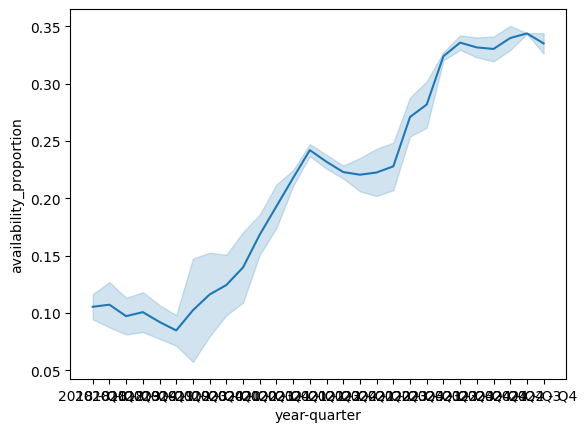

In [30]:
df4_market_vacancy_SF = df4[(df4['market']=='San Francisco') & (df4['internal_class']=='A')]
df4_market_vacancy_SF

df4_market_vacancy_SF['year-quarter'] = df4_market_vacancy_SF['year'].astype(str) + " - " + df4_market_vacancy_SF['quarter'].astype(str)
df4_market_vacancy_SF

df4_market_vacancy_austin = df4[(df4['market']=='Austin') & (df4['internal_class']=='A')]
df4_market_vacancy_austin
df4_market_vacancy_austin['market'].value_counts()

df4_market_vacancy_austin['year-quarter'] = df4_market_vacancy_austin['year'].astype(str) + " - " + df4_market_vacancy_austin['quarter'].astype(str)
df4_market_vacancy_austin

df4['market'] = df4['market'].replace({
    'Chicago Suburbs': 'Chicago',
    'Downtown Chicago': 'Chicago'
})

df4_market_vacancy_chicago = df4[(df4['market']=='Chicago') & (df4['internal_class']=='A')]
df4_market_vacancy_chicago

df4_market_vacancy_chicago['year-quarter'] = df4_market_vacancy_chicago['year'].astype(str) + " - " + df4_market_vacancy_chicago['quarter'].astype(str)
df4_market_vacancy_chicago

#df4_market_vacancy.plot(x= 'year-quarter', y= 'availability_proportion')
#df4_market_vacancy.plot(x='year-quarter', y = 'overall_rent')
combined_df4_market_vacancy = pd.concat([df4_market_vacancy_SF, df4_market_vacancy_austin])
sns.lineplot(data=combined_df4_market_vacancy, x='year-quarter', y='availability_proportion')
df4_market_vacancy_austin['market'].value_counts()



/tmp/ipython-input-31-2648217655.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_manhamttan['year-quarter'] = df4_market_vacancy_manhamttan['year'].astype(str) + " - " + df4_market_vacancy_manhamttan['quarter'].astype(str)


Text(0.5, 1.0, 'Availability Trend: San Francisco vs Austin (Class A)')

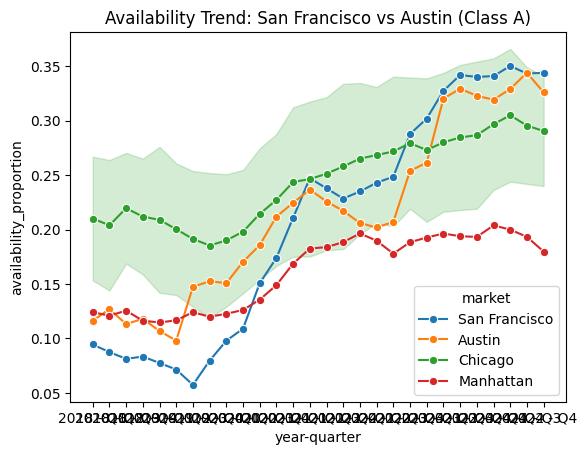

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


df4_market_vacancy_manhamttan = df4[(df4['market']=='Manhattan') & (df4['internal_class']=='A')]
df4_market_vacancy_manhamttan['year-quarter'] = df4_market_vacancy_manhamttan['year'].astype(str) + " - " + df4_market_vacancy_manhamttan['quarter'].astype(str)

# Combine both filtered dataframes
combined_df = pd.concat([df4_market_vacancy_SF, df4_market_vacancy_austin, df4_market_vacancy_chicago, df4_market_vacancy_manhamttan])



sns.lineplot(data=combined_df, x='year-quarter', y='availability_proportion', hue='market', marker='o')
plt.title("Availability Trend: San Francisco vs Austin (Class A)")
#combined_df['market'].value_counts()
#df4_market_vacancy_chicago.head()


<Axes: xlabel='year-quarter', ylabel='overall_rent'>

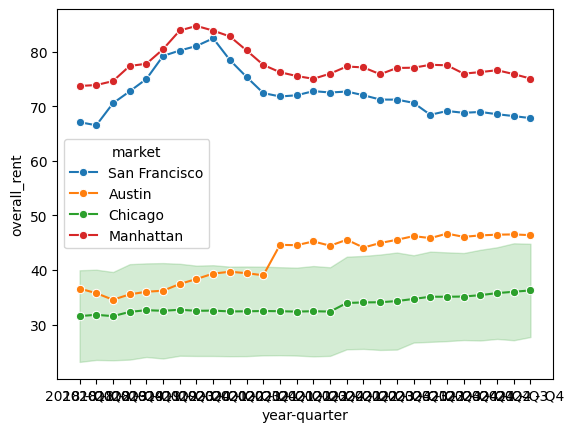

In [32]:
sns.lineplot(data=combined_df, x='year-quarter', y='overall_rent', hue='market', marker='o')


/tmp/ipython-input-33-1539451368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SF_market['year-quarter'] = SF_market['year'].astype(str) + " - " + SF_market['quarter'].astype(str)


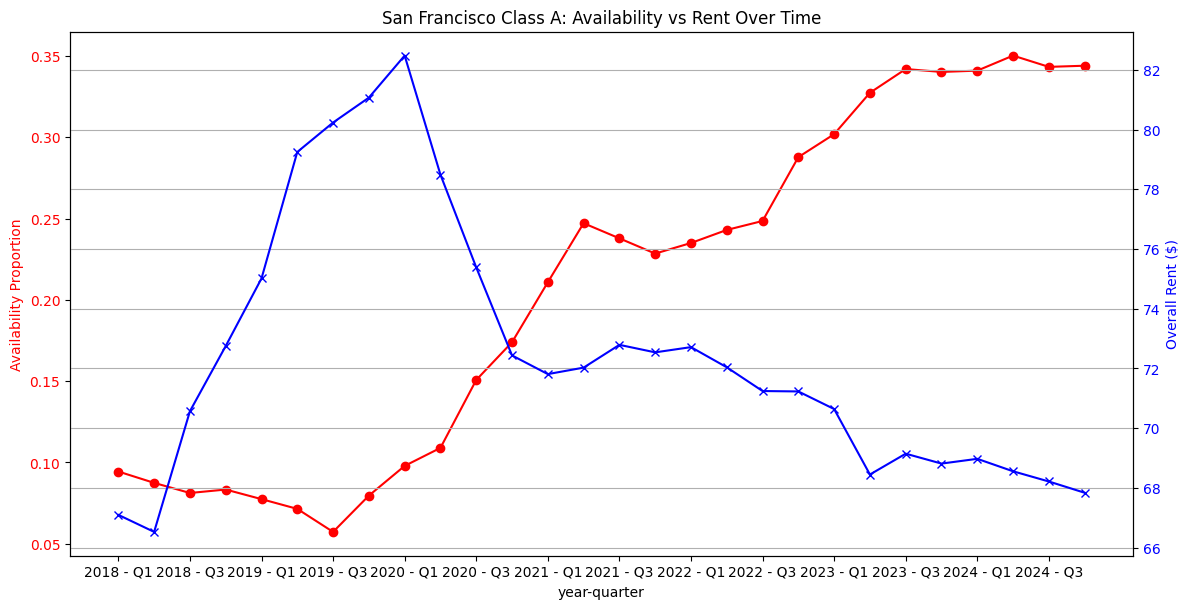

In [33]:
#filtering out to see the market specifically in SF with higher class offices
SF_market = df4[(df4['market']=='San Francisco') & (df4['internal_class']=='A')]
SF_market['year-quarter'] = SF_market['year'].astype(str) + " - " + SF_market['quarter'].astype(str)

sf_trend = SF_market.groupby('year-quarter')[['overall_rent', 'availability_proportion']].mean().reset_index()
sf_trend
sf_trend['year-quarter'] = pd.Categorical(sf_trend['year-quarter'], ordered=True, categories=sf_trend['year-quarter'])

# Order x-axis labels
sf_trend['year-quarter'] = pd.Categorical(sf_trend['year-quarter'], ordered=True, categories=sf_trend['year-quarter'])

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(sf_trend['year-quarter'], sf_trend['availability_proportion'], color='red', marker='o')
ax1.set_ylabel('Availability Proportion', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(sf_trend['year-quarter'], sf_trend['overall_rent'], color='blue', marker='x')
ax2.set_ylabel('Overall Rent ($)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


plt.title("San Francisco Class A: Availability vs Rent Over Time")
plt.xticks(ticks=range(0, len(sf_trend), 2), labels=sf_trend['year-quarter'][::2], rotation=45)
plt.grid(True)
plt.tight_layout()
ax1.set_xlabel('year-quarter')
plt.show()



/tmp/ipython-input-35-710482290.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_houston['year-quarter'] = df4_market_vacancy_houston['year'].astype(str) + " - " + df4_market_vacancy_houston['quarter'].astype(str)
/tmp/ipython-input-35-710482290.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_LA['year-quarter'] = df4_market_vacancy_LA['year'].astype(str) + " - " + df4_market_vacancy_LA['quarter'].astype(str)
/tmp/ipython-input-35-710482290.py:24: SettingWithCop

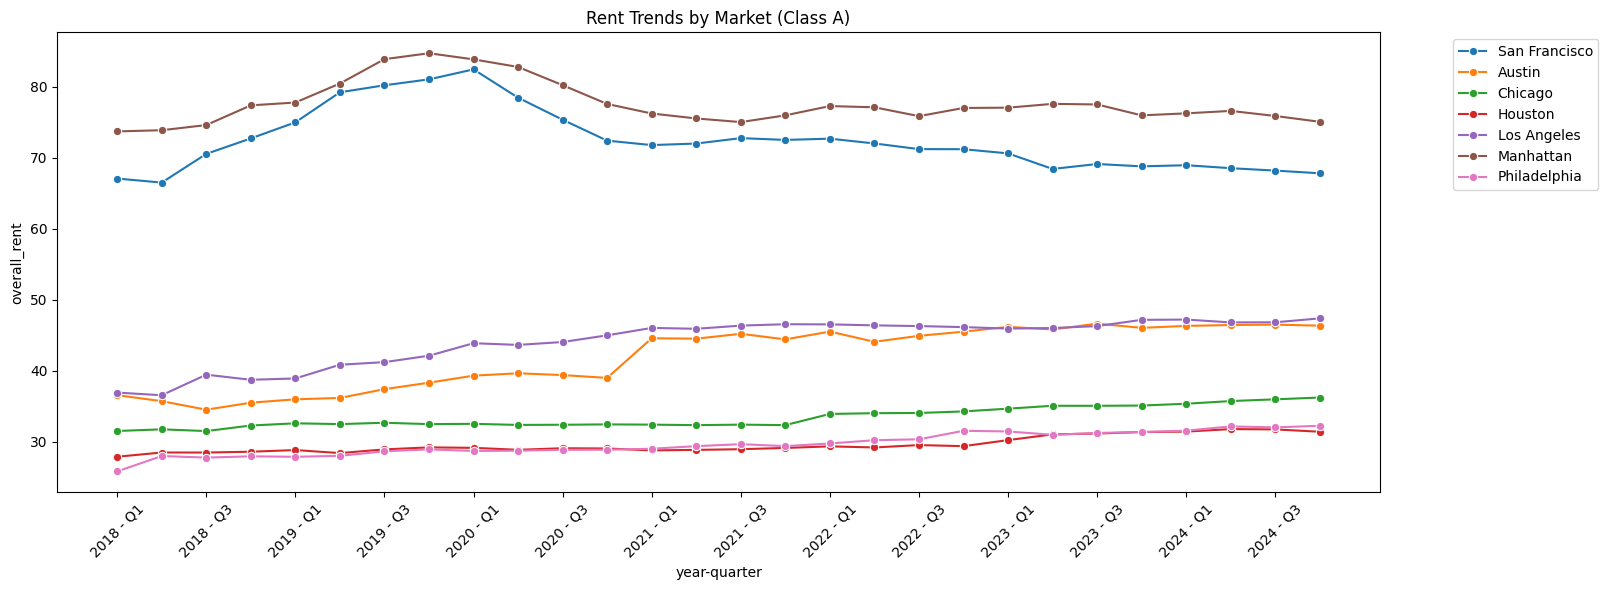

In [35]:
df4_market_vacancy_houston = df4[(df4['market']=='Houston') & (df4['internal_class']=='A')]
df4_market_vacancy_LA = df4[(df4['market']=='Los Angeles') & (df4['internal_class']=='A')]
df4_market_vacancy_manhattan = df4[(df4['market']=='Manhattan') & (df4['internal_class']=='A')]
df4_market_vacancy_other = df4[(df4['market']=='Other') & (df4['internal_class']=='A')]
df4_market_vacancy_philly = df4[(df4['market']=='Philadelphia') & (df4['internal_class']=='A')]
df4_market_vacancy_DC = df4[(df4['market']=='Washington D.C.') & (df4['internal_class']=='A')]

df4['market'] = df4['market'].replace({
    'Dallas': 'Dallas/Ft Worth',
    'Ft Worth': 'Dallash/Ft Worth'
})

df4['market'] = df4['market'].replace({
    'South Bay': 'South Bay/San Jose',
    'San Jose': 'South Bay/San Jose'
})

df4_market_vacancy_DTX = df4[(df4['market']=='Dallas/Ft Worth') & (df4['internal_class']=='A')]
df4_market_vacancy_SBSJ = df4[(df4['market']=='South Bay/San Jose') & (df4['internal_class']=='A')]


df4_market_vacancy_houston['year-quarter'] = df4_market_vacancy_houston['year'].astype(str) + " - " + df4_market_vacancy_houston['quarter'].astype(str)
df4_market_vacancy_LA['year-quarter'] = df4_market_vacancy_LA['year'].astype(str) + " - " + df4_market_vacancy_LA['quarter'].astype(str)
df4_market_vacancy_manhattan['year-quarter'] = df4_market_vacancy_manhattan['year'].astype(str) + " - " + df4_market_vacancy_manhattan['quarter'].astype(str)
df4_market_vacancy_other['year-quarter'] = df4_market_vacancy_other['year'].astype(str) + " - " + df4_market_vacancy_other['quarter'].astype(str)
df4_market_vacancy_philly['year-quarter'] = df4_market_vacancy_philly['year'].astype(str) + " - " + df4_market_vacancy_philly['quarter'].astype(str)
df4_market_vacancy_DC['year-quarter'] = df4_market_vacancy_DC['year'].astype(str) + " - " + df4_market_vacancy_DC['quarter'].astype(str)


combined_df4 = pd.concat([df4_market_vacancy_SF, df4_market_vacancy_austin, df4_market_vacancy_chicago, df4_market_vacancy_houston, df4_market_vacancy_LA,  df4_market_vacancy_manhattan,
                          df4_market_vacancy_other, df4_market_vacancy_philly,  df4_market_vacancy_DC, df4_market_vacancy_DTX, df4_market_vacancy_SBSJ])

combined_df4 = combined_df4.dropna(subset=['year-quarter'])
combined_df4['year-quarter'] = combined_df4['year-quarter'].astype(str)

combined_df4['year-quarter'] = pd.Categorical(combined_df4['year-quarter'], ordered=True, categories=sorted(combined_df4['year-quarter'].unique()))


plt.figure(figsize=(14, 6))
sns.lineplot(data=combined_df4, x='year-quarter', y='overall_rent', hue='market', marker='o', ci=None)

plt.xticks(rotation=45)
plt.title("Rent Trends by Market (Class A)")
unique_labels = combined_df4['year-quarter'].unique()
plt.xticks(ticks=range(0, len(unique_labels), 2), labels=unique_labels[::2], rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # optional: move legend outside
plt.show()







/tmp/ipython-input-40-949181134.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_houston['year-quarter'] = df4_market_vacancy_houston['year'].astype(str) + " - " + df4_market_vacancy_houston['quarter'].astype(str)
/tmp/ipython-input-40-949181134.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancy_LA['year-quarter'] = df4_market_vacancy_LA['year'].astype(str) + " - " + df4_market_vacancy_LA['quarter'].astype(str)
/tmp/ipython-input-40-949181134.py:24: SettingWithCop

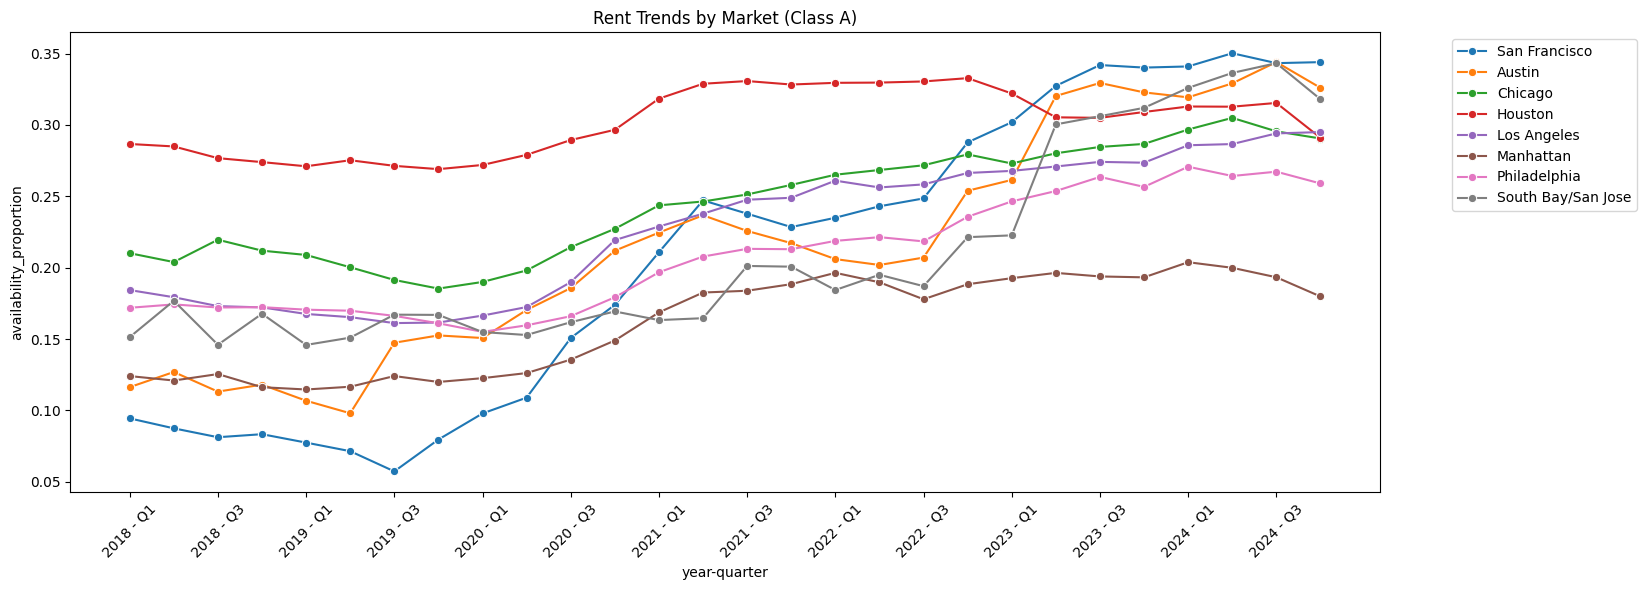

In [40]:
df4_market_vacancy_houston = df4[(df4['market']=='Houston') & (df4['internal_class']=='A')]
df4_market_vacancy_LA = df4[(df4['market']=='Los Angeles') & (df4['internal_class']=='A')]
df4_market_vacancy_manhattan = df4[(df4['market']=='Manhattan') & (df4['internal_class']=='A')]
df4_market_vacancy_other = df4[(df4['market']=='Other') & (df4['internal_class']=='A')]
df4_market_vacancy_philly = df4[(df4['market']=='Philadelphia') & (df4['internal_class']=='A')]
df4_market_vacancy_DC = df4[(df4['market']=='Washington D.C.') & (df4['internal_class']=='A')]

df4['market'] = df4['market'].replace({
    'Dallas': 'Dallas/Ft Worth',
    'Ft Worth': 'Dallash/Ft Worth'
})

df4['market'] = df4['market'].replace({
    'South Bay': 'South Bay/San Jose',
    'San Jose': 'South Bay/San Jose'
})

df4_market_vacancy_DTX = df4[(df4['market']=='Dallas/Ft Worth') & (df4['internal_class']=='A')]
df4_market_vacancy_SBSJ = df4[(df4['market']=='South Bay/San Jose') & (df4['internal_class']=='A')]


df4_market_vacancy_houston['year-quarter'] = df4_market_vacancy_houston['year'].astype(str) + " - " + df4_market_vacancy_houston['quarter'].astype(str)
df4_market_vacancy_LA['year-quarter'] = df4_market_vacancy_LA['year'].astype(str) + " - " + df4_market_vacancy_LA['quarter'].astype(str)
df4_market_vacancy_manhattan['year-quarter'] = df4_market_vacancy_manhattan['year'].astype(str) + " - " + df4_market_vacancy_manhattan['quarter'].astype(str)
df4_market_vacancy_other['year-quarter'] = df4_market_vacancy_other['year'].astype(str) + " - " + df4_market_vacancy_other['quarter'].astype(str)
df4_market_vacancy_philly['year-quarter'] = df4_market_vacancy_philly['year'].astype(str) + " - " + df4_market_vacancy_philly['quarter'].astype(str)
df4_market_vacancy_DC['year-quarter'] = df4_market_vacancy_DC['year'].astype(str) + " - " + df4_market_vacancy_DC['quarter'].astype(str)


combined_df4 = pd.concat([df4_market_vacancy_SF, df4_market_vacancy_austin, df4_market_vacancy_chicago, df4_market_vacancy_houston, df4_market_vacancy_LA,  df4_market_vacancy_manhattan,
                          df4_market_vacancy_other, df4_market_vacancy_philly,  df4_market_vacancy_DC, df4_market_vacancy_DTX, df4_market_vacancy_SBSJ])

combined_df4 = combined_df4.dropna(subset=['year-quarter'])
combined_df4['year-quarter'] = combined_df4['year-quarter'].astype(str)

combined_df4['year-quarter'] = pd.Categorical(combined_df4['year-quarter'], ordered=True, categories=sorted(combined_df4['year-quarter'].unique()))


plt.figure(figsize=(14, 6))
sns.lineplot(data=combined_df4, x='year-quarter', y='availability_proportion', hue='market', marker='o', ci=None)

plt.xticks(rotation=45)
plt.title("Rent Trends by Market (Class A)")
unique_labels = combined_df4['year-quarter'].unique()
plt.xticks(ticks=range(0, len(unique_labels), 2), labels=unique_labels[::2], rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # optional: move legend outside
plt.show()




/tmp/ipython-input-36-1777709565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_market_vacancyy['year-quarter'] = df4_market_vacancyy['year'].astype(str) + " - " + df4_market_vacancyy['quarter'].astype(str)


<Axes: xlabel='year-quarter'>

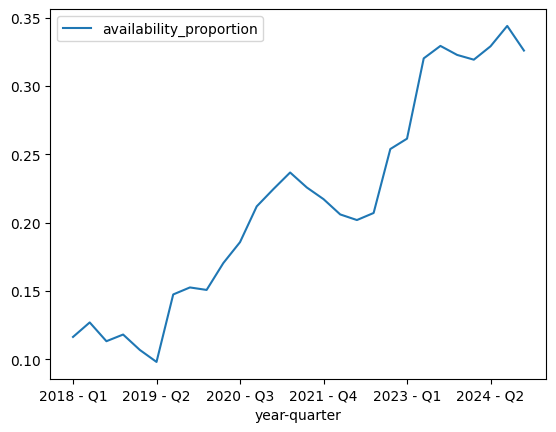

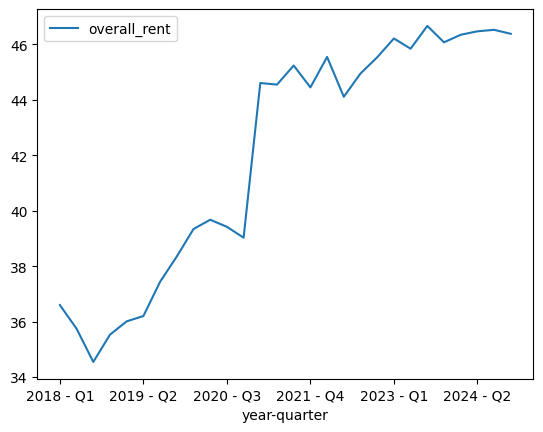

In [36]:
df4_market_vacancyy = df4[(df4['market']=='Austin') & (df4['internal_class']=='A')]
df4_market_vacancyy

df4_market_vacancyy['year-quarter'] = df4_market_vacancyy['year'].astype(str) + " - " + df4_market_vacancyy['quarter'].astype(str)
df4_market_vacancyy


df4_market_vacancyy.plot(x= 'year-quarter', y= 'availability_proportion')
df4_market_vacancyy.plot(x='year-quarter', y = 'overall_rent')


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'RBA'}>,
        <Axes: title={'center': 'available_space'}>,
        <Axes: title={'center': 'availability_proportion'}>],
       [<Axes: title={'center': 'internal_class_rent'}>,
        <Axes: title={'center': 'overall_rent'}>,
        <Axes: title={'center': 'direct_available_space'}>,
        <Axes: title={'center': 'direct_availability_proportion'}>],
       [<Axes: title={'center': 'direct_internal_class_rent'}>,
        <Axes: title={'center': 'direct_overall_rent'}>,
        <Axes: title={'center': 'sublet_available_space'}>,
        <Axes: title={'center': 'sublet_availability_proportion'}>],
       [<Axes: title={'center': 'sublet_internal_class_rent'}>,
        <Axes: title={'center': 'sublet_overall_rent'}>,
        <Axes: title={'center': 'leasing'}>, <Axes: >]], dtype=object)

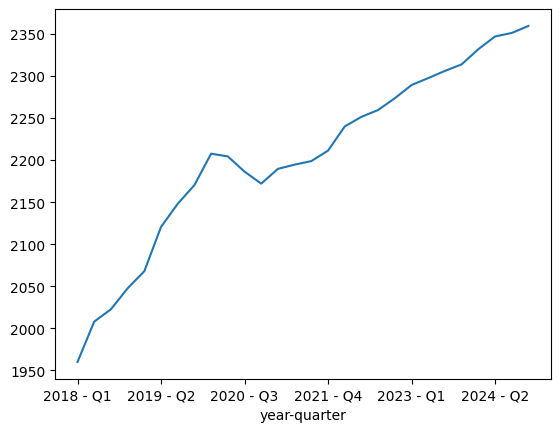

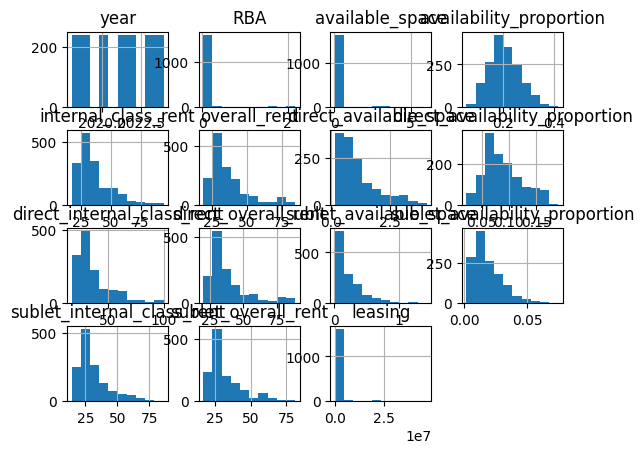

In [37]:
df4['year-quarter'] = df4['year'].astype(str) + " - " + df4['quarter'].astype(str)
df4.groupby('year-quarter')['overall_rent'].sum().plot()
df4.hist()

In [39]:
something = pd.read_csv('/Unemployment.csv')

something.head

<bound method NDFrame.head of       year quarter  month state  unemployment_rate
0     2018      Q1      1    AZ                4.9
1     2018      Q1      1    CA                4.4
2     2018      Q1      1    CO                2.9
3     2018      Q1      1    DE                4.1
4     2018      Q1      1    DC                5.9
...    ...     ...    ...   ...                ...
1843  2024      Q4     12    TN                3.6
1844  2024      Q4     12    TX                4.2
1845  2024      Q4     12    UT                3.5
1846  2024      Q4     12    VA                3.0
1847  2024      Q4     12    WA                4.5

[1848 rows x 5 columns]>